In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind
import matplotlib.gridspec as gridspec
import mne
from matplotlib import ticker

In [2]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

def add_subplot_label(ax, label, x=-.21, y=1.225):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=26, va='top', ha='right')

In [3]:
behav_df = pd.read_csv('./data/derivatives/behav_df_cleaned_new.csv')
behav_df = behav_df[behav_df['reach_vis_abs_err']<=60].reset_index(drop=True)

burst_df = pd.read_csv('./data/derivatives/burst_features.csv')

lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject", "group"]]
df_burst_behav = burst_df.merge(
    lookup_df, 
    on=["trial", "block", "subject"], 
    how='left'
)

In [4]:
burst_df_vis = df_burst_behav[df_burst_behav['epoch'] == 'vis']
burst_df_mot = df_burst_behav[df_burst_behav['epoch'] == 'mot']

# Save to CSV
burst_df_vis.to_csv('./output/burst_features_vis.csv', index=False)
burst_df_mot.to_csv('./output/burst_features_mot.csv', index=False)

In [5]:
waveform_array_file = './data/derivatives/all_waveforms.npy'
waveform_array = np.load(waveform_array_file)
waveform_time = np.linspace(-.13, .13, num=156)

In [6]:
implicit_subjects = behav_df[behav_df['group'] == 'Implicit']['subject'].unique()
explicit_subjects = behav_df[behav_df['group'] == 'Explicit']['subject'].unique()

In [7]:
mask_visual_implicit = (
    (df_burst_behav["epoch"] == "vis") &
    (df_burst_behav["subject"].isin(implicit_subjects))
)
waveform_array_implicit_visual = waveform_array[mask_visual_implicit, :]

mask_visual_explicit = (
    (df_burst_behav["epoch"] == "vis") &
    (df_burst_behav["subject"].isin(explicit_subjects))
)
waveform_array_explicit_visual = waveform_array[mask_visual_explicit, :]


mask_motor_implicit = (
    (df_burst_behav["epoch"] == "mot") &
    (df_burst_behav["subject"].isin(implicit_subjects))
)
waveform_array_implicit_motor = waveform_array[mask_motor_implicit, :]

mask_motor_explicit = (
    (df_burst_behav["epoch"] == "mot") &
    (df_burst_behav["subject"].isin(explicit_subjects))
)
waveform_array_explicit_motor = waveform_array[mask_motor_explicit, :]

In [8]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNR = signaltonoise(waveform_array, axis=0, ddof=1)

In [9]:
mean_waveform_implicit_visual = waveform_array_implicit_visual.mean(axis=0)
mean_waveform_explicit_visual = waveform_array_explicit_visual.mean(axis=0)
mean_waveform_implicit_motor = waveform_array_implicit_motor.mean(axis=0)
mean_waveform_explicit_motor = waveform_array_explicit_motor.mean(axis=0)

SNR_implicit_visual = signaltonoise(waveform_array_implicit_visual, axis=0, ddof=1)
SNR_explicit_visual = signaltonoise(waveform_array_explicit_visual, axis=0, ddof=1)
SNR_implicit_motor = signaltonoise(waveform_array_implicit_motor, axis=0, ddof=1)
SNR_explicit_motor = signaltonoise(waveform_array_explicit_motor, axis=0, ddof=1)

In [10]:
# Convert time to ms
waveform_time_ms = waveform_time * 1000


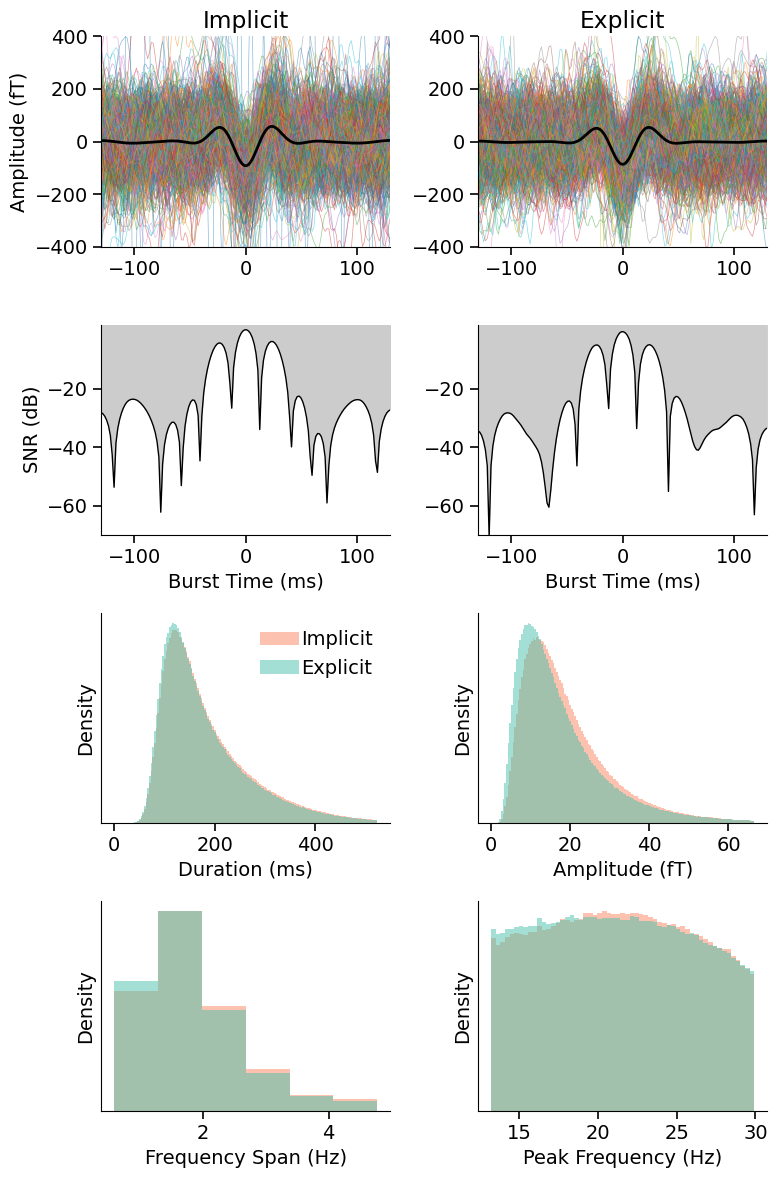

In [41]:
palette0 = sns.color_palette("magma_r", 3)
palette1 = sns.color_palette("mako_r", 3)
    
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(4, 2)

ax1 = fig.add_subplot(gs[0, 0])   # Implicit waveforms
ax2 = fig.add_subplot(gs[0, 1])   # Explicit waveforms
ax3 = fig.add_subplot(gs[1, 0])   # Implicit SNR
ax4 = fig.add_subplot(gs[1, 1])   # Explicit SNR
ax5 = fig.add_subplot(gs[2, 0])   # Duration
ax6 = fig.add_subplot(gs[2, 1])   # Amplitude
ax7 = fig.add_subplot(gs[3, 0])   # Freq span
ax8 = fig.add_subplot(gs[3, 1])   # Peak freq

# Implicit Waveforms
ax1.plot(
    waveform_time_ms,
    waveform_array_implicit_visual[::5000].T / 1e-15,  # downsample if needed
    lw=0.5, alpha=0.5,
    rasterized=True
)
ax1.plot(
    waveform_time_ms,
    mean_waveform_implicit_visual / 1e-15,
    lw=2, color="black"
)
ax1.set_ylim(-400, 400)
ax1.set_xlim(-130, 130)
ax1.set_ylabel("Amplitude (fT)")
ax1.set_title("Implicit")

# Implicit SNR
ax3.fill_between(
    waveform_time_ms,
    np.zeros_like(waveform_time_ms)+2,
    10 * np.log10(SNR_implicit_visual**2),
    lw=0, color="black", alpha=0.2
)
ax3.plot(
    waveform_time_ms,
    10 * np.log10(SNR_implicit_visual**2),
    lw=1, color="black"
)
ax3.set_ylim(-70, 2)
ax3.set_xlim(-130, 130)
ax3.set_ylabel("SNR (dB)")
ax3.set_yticks([-20, -40, -60])
ax3.set_xlabel("Burst Time (ms)")

# Explicit Waveforms
ax2.plot(
    waveform_time_ms,
    waveform_array_explicit_visual[::5000].T / 1e-15,
    lw=0.5, alpha=0.5,
    rasterized=True
)
ax2.plot(
    waveform_time_ms,
    mean_waveform_explicit_visual / 1e-15,
    lw=2, color="black"
)
ax2.set_ylim(-400, 400)
ax2.set_xlim(-130, 130)
ax2.set_title("Explicit")

# Explicit SNR
ax4.fill_between(
    waveform_time_ms,
    np.zeros_like(waveform_time_ms)+2,
    10 * np.log10(SNR_explicit_visual**2),
    lw=0, color="black", alpha=0.2
)
ax4.plot(
    waveform_time_ms,
    10 * np.log10(SNR_explicit_visual**2),
    lw=1, color="black"
)
ax4.set_ylim(-70, 2)
ax4.set_xlim(-130, 130)
ax4.set_yticks([-20, -40, -60])
ax4.set_xlabel("Burst Time (ms)")

# Duration
fwhm_implicit=df_burst_behav['fwhm_time'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='vis')]*1000
fwhm_explicit=df_burst_behav['fwhm_time'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='vis')]*1000
combined_values = np.concatenate([fwhm_implicit, fwhm_explicit])
max_val = np.percentile(combined_values, 99)
bins = np.linspace(0, max_val, 159)
ax5.hist(
    fwhm_implicit,
    bins=bins,
    color=palette0[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Implicit"
)
ax5.hist(
    fwhm_explicit,
    bins=bins,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)
ax5.set_xlabel("Duration (ms)")
ax5.set_ylabel("Density")
ax5.set_yticks([])
ax5.legend()

# Amplitude
peak_amp_base_implicit=df_burst_behav['peak_amp_base'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='vis')] * 1e15
peak_amp_base_explicit=df_burst_behav['peak_amp_base'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='vis')] * 1e15
combined_values = np.concatenate([peak_amp_base_implicit, peak_amp_base_explicit])
min_val = np.min(combined_values)
max_val = np.percentile(combined_values, 99)
bins = np.linspace(min_val, max_val, 159)
ax6.hist(
    peak_amp_base_implicit, bins=bins, alpha=0.5, density=True, label="Implicit", color=palette0[0],
)
ax6.hist(
    peak_amp_base_explicit, bins=bins, alpha=0.5, density=True, label="Explicit", color=palette1[0],
)
ax6.set_xlabel("Amplitude (fT)")
ax6.set_ylabel("Density")
ax6.set_yticks([])

# Frequency span
fwhm_freq_implicit=df_burst_behav['fwhm_freq'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='vis')]
fwhm_freq_explicit=df_burst_behav['fwhm_freq'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='vis')]
combined_values = np.concatenate([fwhm_freq_implicit, fwhm_freq_explicit])
min_val = np.min(combined_values)
max_val = np.percentile(combined_values, 99)
bins = np.linspace(min_val, max_val, 7)
ax7.hist(
    fwhm_freq_implicit,
    bins=bins,
    color=palette0[0],
    alpha=0.5,             
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax7.hist(
    fwhm_freq_explicit,
    bins=bins,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)
ax7.set_xlabel("Frequency Span (Hz)")
ax7.set_ylabel("Density")
ax7.set_yticks([])

# Peak frequency
peak_freq_implicit=df_burst_behav['peak_freq'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='vis')]
peak_freq_explicit=df_burst_behav['peak_freq'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='vis')]
combined_values = np.concatenate([peak_freq_implicit, peak_freq_explicit])
min_val = np.min(combined_values)
max_val = np.max(combined_values)
bins = np.linspace(min_val, max_val, 58)
ax8.hist(
    peak_freq_implicit,
    bins=bins,
    color=palette0[0],
    alpha=0.5,              # transparency
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax8.hist(
    peak_freq_explicit,
    bins=bins,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)
ax8.set_xlabel("Peak Frequency (Hz)")
ax8.set_ylabel("Density")
ax8.set_yticks([])

plt.tight_layout()
plt.show()

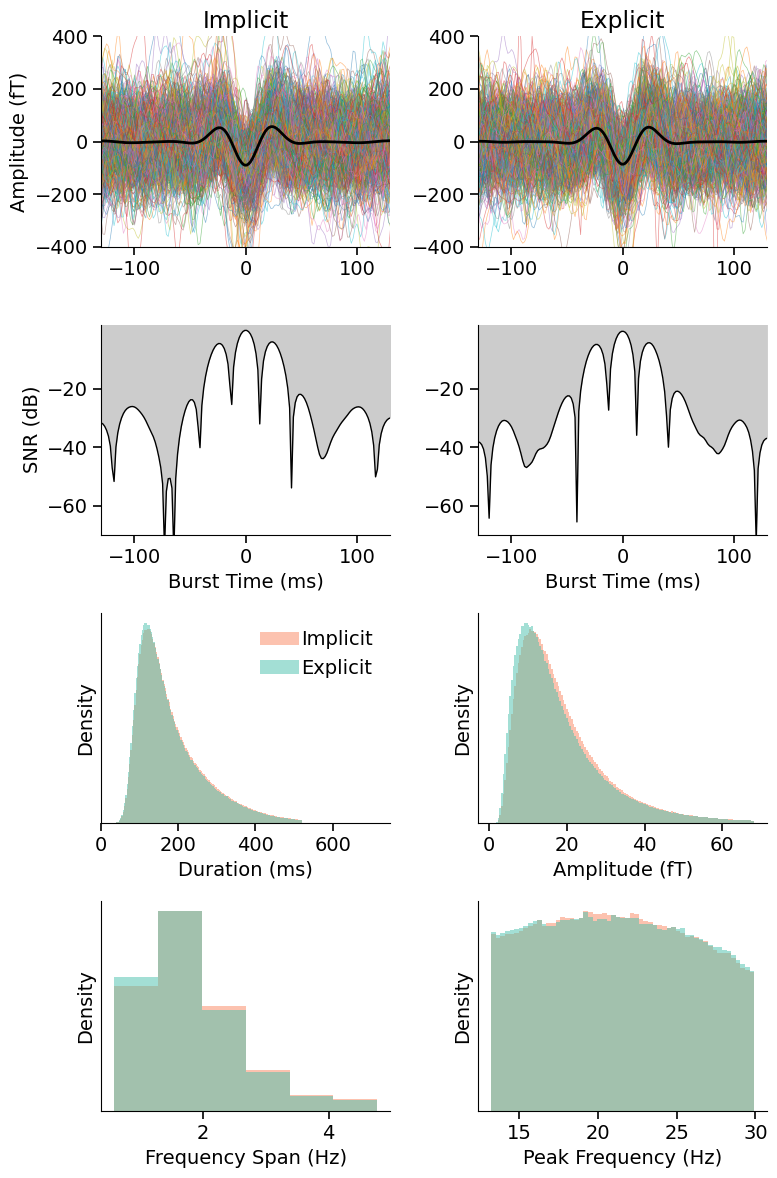

In [42]:
palette0 = sns.color_palette("magma_r", 3)
palette1 = sns.color_palette("mako_r", 3)
    
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(4, 2)

ax1 = fig.add_subplot(gs[0, 0])   # Implicit waveforms
ax2 = fig.add_subplot(gs[0, 1])   # Explicit waveforms
ax3 = fig.add_subplot(gs[1, 0])   # Implicit SNR
ax4 = fig.add_subplot(gs[1, 1])   # Explicit SNR
ax5 = fig.add_subplot(gs[2, 0])   # Duration
ax6 = fig.add_subplot(gs[2, 1])   # Amplitude
ax7 = fig.add_subplot(gs[3, 0])   # Freq span
ax8 = fig.add_subplot(gs[3, 1])   # Peak freq

# Implicit Waveforms
ax1.plot(
    waveform_time_ms,
    waveform_array_implicit_motor[::5000].T / 1e-15,  # downsample if needed
    lw=0.5, alpha=0.5,
    rasterized=True
)
ax1.plot(
    waveform_time_ms,
    mean_waveform_implicit_motor / 1e-15,
    lw=2, color="black"
)
ax1.set_ylim(-400, 400)
ax1.set_xlim(-130, 130)
ax1.set_ylabel("Amplitude (fT)")
ax1.set_title("Implicit")

# Implicit SNR
ax3.fill_between(
    waveform_time_ms,
    np.zeros_like(waveform_time_ms)+2,
    10 * np.log10(SNR_implicit_motor**2),
    lw=0, color="black", alpha=0.2
)
ax3.plot(
    waveform_time_ms,
    10 * np.log10(SNR_implicit_motor**2),
    lw=1, color="black"
)
ax3.set_ylim(-70, 2)
ax3.set_xlim(-130, 130)
ax3.set_ylabel("SNR (dB)")
ax3.set_yticks([-20, -40, -60])
ax3.set_xlabel("Burst Time (ms)")

# Explicit Waveforms
ax2.plot(
    waveform_time_ms,
    waveform_array_explicit_motor[::5000].T / 1e-15,
    lw=0.5, alpha=0.5,
    rasterized=True
)
ax2.plot(
    waveform_time_ms,
    mean_waveform_explicit_motor / 1e-15,
    lw=2, color="black"
)
ax2.set_ylim(-400, 400)
ax2.set_xlim(-130, 130)
ax2.set_title("Explicit")

# Explicit SNR
ax4.fill_between(
    waveform_time_ms,
    np.zeros_like(waveform_time_ms)+2,
    10 * np.log10(SNR_explicit_motor**2),
    lw=0, color="black", alpha=0.2
)
ax4.plot(
    waveform_time_ms,
    10 * np.log10(SNR_explicit_motor**2),
    lw=1, color="black"
)
ax4.set_ylim(-70, 2)
ax4.set_xlim(-130, 130)
ax4.set_yticks([-20, -40, -60])
ax4.set_xlabel("Burst Time (ms)")

# Duration
fwhm_implicit=df_burst_behav['fwhm_time'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='mot')]*1000
fwhm_explicit=df_burst_behav['fwhm_time'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='mot')]*1000
combined_values = np.concatenate([fwhm_implicit, fwhm_explicit])
max_val = np.percentile(combined_values, 99)
bins = np.linspace(0, max_val, 158)
ax5.hist(
    fwhm_implicit,
    bins=bins,
    color=palette0[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Implicit"
)
ax5.hist(
    fwhm_explicit,
    bins=bins,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)
ax5.set_xlabel("Duration (ms)")
ax5.set_ylabel("Density")
ax5.set_xlim(0, 750)
ax5.set_yticks([])
ax5.legend()

# Amplitude
peak_amp_base_implicit=df_burst_behav['peak_amp_base'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='mot')] * 1e15
peak_amp_base_explicit=df_burst_behav['peak_amp_base'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='mot')] * 1e15
combined_values = np.concatenate([peak_amp_base_implicit, peak_amp_base_explicit])
min_val = np.min(combined_values)
max_val = np.percentile(combined_values, 99)
bins = np.linspace(min_val, max_val, 159)
ax6.hist(
    peak_amp_base_implicit, bins=bins, alpha=0.5, density=True, label="Implicit", color=palette0[0],
)
ax6.hist(
    peak_amp_base_explicit, bins=bins, alpha=0.5, density=True, label="Explicit", color=palette1[0],
)
ax6.set_xlabel("Amplitude (fT)")
ax6.set_ylabel("Density")
ax6.set_yticks([])

# Frequency span
fwhm_freq_implicit=df_burst_behav['fwhm_freq'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='mot')]
fwhm_freq_explicit=df_burst_behav['fwhm_freq'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='mot')]
combined_values = np.concatenate([fwhm_freq_implicit, fwhm_freq_explicit])
min_val = np.min(combined_values)
max_val = np.percentile(combined_values, 99)
bins = np.linspace(min_val, max_val, 7)
ax7.hist(
    fwhm_freq_implicit,
    bins=bins,
    color=palette0[0],
    alpha=0.5,             
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax7.hist(
    fwhm_freq_explicit,
    bins=bins,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)
ax7.set_xlabel("Frequency Span (Hz)")
ax7.set_ylabel("Density")
ax7.set_yticks([])

# Peak frequency
peak_freq_implicit=df_burst_behav['peak_freq'][(df_burst_behav['group']=='Implicit') & (df_burst_behav['epoch']=='mot')]
peak_freq_explicit=df_burst_behav['peak_freq'][(df_burst_behav['group']=='Explicit') & (df_burst_behav['epoch']=='mot')]
combined_values = np.concatenate([peak_freq_implicit, peak_freq_explicit])
min_val = np.min(combined_values)
max_val = np.max(combined_values)
bins = np.linspace(min_val, max_val, 58)
ax8.hist(
    peak_freq_implicit,
    bins=bins,
    color=palette0[0],
    alpha=0.5,              # transparency
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax8.hist(
    peak_freq_explicit,
    bins=bins,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)
ax8.set_xlabel("Peak Frequency (Hz)")
ax8.set_ylabel("Density")
ax8.set_yticks([])

plt.tight_layout()
plt.show()